In [16]:
# ! pip install fbprophet
# ! pip install statsmodels
# ! pip install scipy

In [49]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
import datetime
import scipy
import time

JUST_TESTING = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
COLS_FROM_CORE_PLACES = ['safegraph_place_id', 'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids', 
                         'brands', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
                         'city', 'region', 'postal_code', 'open_hours']

COLS_FROM_CORE_PLACES_FOOTPRINT = ['safegraph_place_id', 'polygon_class', 'area_square_feet', 'min_area']

COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
                             'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']

## Load the core_POI

In [4]:
# The path is: /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00
#   # No column of safegraph_place_id since July
core_poi_df = helper.load_core_places_data(COLS_FROM_CORE_PLACES)

Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part1.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part2.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part3.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part4.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part5.csv.gz
Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part6.csv.gz
Loading core places info for 6462532 POIs


## Load the area column to the CORE_POIs.


In [5]:
def load_core_places_footprint_data(cols_to_keep):
    FOOTPRINT_FILE = r'/media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/core_POI_area.csv' 
    area_csv = os.path.join(FOOTPRINT_FILE)
    print('Loading', area_csv)
    df = load_csv_possibly_with_dask(area_csv, usecols=cols_to_keep, use_dask=False)
    df = df.set_index('safegraph_place_id')
    print('Loaded core places footprint data for %d POIs' % len(df))
    return df

# footprint_df = helper.load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)
footprint_df = load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/core_POI_area.csv
Loaded core places footprint data for 5941711 POIs


In [6]:
footprint_df['area_square_feet'] = footprint_df['min_area']
footprint_df

,polygon_class,area_square_feet,min_area
safegraph_place_id,,,
sg:000000c8f55d451ca1ae98bd057785a7,OWNED_POLYGON,239.658301,239.658301
sg:000008c003ab41d9b6a8d1e58e4992ea,OWNED_POLYGON,95.644273,95.644273
sg:0000093d8e7741e8a2a7ab13d432aaa2,NaN,376.543914,376.543914
sg:00000a99a12a45cd80342b9f881eced6,NaN,1236.058087,1236.058087
sg:00000b5b33aa4d27a98b815f163ccd3b,OWNED_POLYGON,181.531029,181.531029
...,...,...,...
sg:fffff90467044c7789e1594fdae67934,NaN,204.502240,204.502240
sg:fffff977b3324b7eac27c39b3036ff0f,NaN,668.063234,668.063234
sg:fffffafcfc1246349f856586a4f92d74,OWNED_POLYGON,3358.956378,3358.956378


In [20]:
footprint_df['area_square_feet'].isna().sum()

0

In [21]:
# footprint_df = helper.load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)
ids_in_footprint_but_not_core = set(footprint_df.index) - set(core_poi_df.index)
print(f"footprint_df row count: {len(footprint_df)}, core_POI row count: {len(core_poi_df)}")
print("Warning: %i/%i (%.1f%%) POIs in footprint but not core data; dropping these" % 
      (len(ids_in_footprint_but_not_core), len(footprint_df), 100. * len(ids_in_footprint_but_not_core) / len(footprint_df)))
core_poi_df = pd.merge(core_poi_df, footprint_df, how='left', left_index=True, right_index=True, validate='one_to_one')
print("Missing data for footprint columns")
print(pd.isnull(core_poi_df[footprint_df.columns]).mean())

footprint_df row count: 5941711, core_POI row count: 77727
Missing data for footprint columns
polygon_class       0.152624
area_square_feet    0.000000
min_area            0.000000
dtype: float64


In [22]:
core_poi_df[footprint_df.columns]

,polygon_class,area_square_feet,min_area
safegraph_place_id,,,
sg:0123236b8d4c4e81ac12673c3e621ef0,OWNED_POLYGON,223.894463,223.894463
sg:0ff4a57b4adb42438cd1d08f0626fbef,OWNED_POLYGON,156.261613,156.261613
sg:1013084d2ba849988ce408184cd577ef,OWNED_POLYGON,1541.991825,1541.991825
sg:1cc9444a2da849f4b6e21e286c0e77a2,OWNED_POLYGON,220.145583,220.145583
sg:216dc4238fc44bfea9b57955acc60d63,SHARED_POLYGON,1366.579064,1366.579064
...,...,...,...
sg:d807350cee1a45a6a55bca0b140b1075,OWNED_POLYGON,1574.414716,1574.414716
sg:e0bc6f91630e4f64875d6a520cf9b0d3,SHARED_POLYGON,393.038655,393.038655
sg:e5292fd98e4e373ea9423b1129479957,NaN,289.754907,289.754907


In [23]:
print(f'Row count of core_poi_df: {len(core_poi_df)}')
core_poi_df.head(3)

Row count of core_poi_df: 77727


,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,...,open_hours,polygon_class_x,area_square_feet_x,min_area_x,polygon_class_y,area_square_feet_y,min_area_y,polygon_class,area_square_feet,min_area
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:0123236b8d4c4e81ac12673c3e621ef0,NaN,Toby's TNT Music,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,33.516832,-81.847263,2868 Augusta Rd,...,"{ ""Mon"": [[""9:30"", ""18:00""]], ""Tue"": [[""9:30"",...",OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463
sg:0ff4a57b4adb42438cd1d08f0626fbef,NaN,Southern Tire of Summerville,NaN,NaN,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,32.985588,-80.176531,427 Old Trolley Rd,...,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613
sg:1013084d2ba849988ce408184cd577ef,NaN,ALDI,SG_BRAND_41267d9fb3826d417e32077a3b0a35e5,ALDI,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,35.052030,-80.991332,3665 Vandora Springs Rd,...,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825


# Combine Core/Footprint/Weekly data and write out to MSA files

In this section, we process the raw SafeGraph Weekly Patterns data and divide the processing output into separate csv files per metropolitan statistical area (MSA). In processing the data, we:
- Expand the visits_by_each_hour column into one column per hour.
- Correct the visit spikes at the GMT midnight boundary (this is a known error with hourly SafeGraph data).
- Drop parent POIs so we don't double-count visits.
- Add an MSA column based on the POI's census block group (if that information is provided).

## Set the start/end date

In [43]:
# first and last week of the latest Weekly data to process
start_date = datetime.datetime(2020, 6, 29)   # Should be the data release date, i.e., the csv file name
end_date = datetime.datetime(2020, 8, 10)
print('Time period: %s to %s (%s)' % (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), end_date - start_date))

Time period: 2020-06-29 to 2020-08-10 (42 days, 0:00:00)


In [36]:
# Select the South Carolina 
core_poi_df = core_poi_df[core_poi_df['region'] == 'SC']
core_poi_df

,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,...,open_hours,polygon_class_x,area_square_feet_x,min_area_x,polygon_class_y,area_square_feet_y,min_area_y,polygon_class,area_square_feet,min_area
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:0123236b8d4c4e81ac12673c3e621ef0,NaN,Toby's TNT Music,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,33.516832,-81.847263,2868 Augusta Rd,...,"{ ""Mon"": [[""9:30"", ""18:00""]], ""Tue"": [[""9:30"",...",OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463
sg:0ff4a57b4adb42438cd1d08f0626fbef,NaN,Southern Tire of Summerville,NaN,NaN,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,32.985588,-80.176531,427 Old Trolley Rd,...,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613
sg:1013084d2ba849988ce408184cd577ef,NaN,ALDI,SG_BRAND_41267d9fb3826d417e32077a3b0a35e5,ALDI,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,35.052030,-80.991332,3665 Vandora Springs Rd,...,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825
sg:1cc9444a2da849f4b6e21e286c0e77a2,NaN,Morgans Pharmacy,NaN,NaN,Health and Personal Care Stores,Pharmacies and Drug Stores,446110.0,33.922200,-81.399060,309 Broad St,...,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,220.145583,220.145583,OWNED_POLYGON,220.145583,220.145583,OWNED_POLYGON,220.145583,220.145583
sg:216dc4238fc44bfea9b57955acc60d63,NaN,Kevin Harpe Insurance,NaN,NaN,"Agencies, Brokerages, and Other Insurance Rela...",Insurance Agencies and Brokerages,524210.0,34.851440,-82.397305,105 N Spring St Ste 109,...,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",SHARED_POLYGON,1366.579064,1366.579064,SHARED_POLYGON,1366.579064,1366.579064,SHARED_POLYGON,1366.579064,1366.579064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sg:d807350cee1a45a6a55bca0b140b1075,NaN,Northside United Methodist Church,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,34.875737,-82.384363,435 Summit Dr,...,NaN,OWNED_POLYGON,1574.414716,1574.414716,OWNED_POLYGON,1574.414716,1574.414716,OWNED_POLYGON,1574.414716,1574.414716
sg:e0bc6f91630e4f64875d6a520cf9b0d3,NaN,Galen Laser Aesthetics,NaN,NaN,Personal Care Services,Other Personal Care Services,812199.0,34.950970,-82.238985,501 Memorial Drive Ext Unit C,...,"{ ""Mon"": [[""9:00"", ""17:00""]], ""Tue"": [[""9:00"",...",SHARED_POLYGON,393.038655,393.038655,SHARED_POLYGON,393.038655,393.038655,SHARED_POLYGON,393.038655,393.038655
sg:e5292fd98e4e373ea9423b1129479957,NaN,Swami Food Store,NaN,NaN,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,34.513375,-82.664592,830 Bleckley St,...,NaN,NaN,289.754907,289.754907,NaN,289.754907,289.754907,NaN,289.754907,289.754907


In [37]:
# Remove parent POIs
parent_pois_id = core_poi_df.dropna(subset=['parent_safegraph_place_id'])['parent_safegraph_place_id'].unique()
print(f"Found {len(parent_pois_id)} parent POIs.")
parent_idx = core_poi_df['parent_safegraph_place_id'].isin(parent_pois_id)
core_poi_df = core_poi_df[~parent_idx]
core_poi_df

Found 0 parent POIs.


,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,...,open_hours,polygon_class_x,area_square_feet_x,min_area_x,polygon_class_y,area_square_feet_y,min_area_y,polygon_class,area_square_feet,min_area
safegraph_place_id,,,,,,,,,,,,,,,,,,,,,
sg:0123236b8d4c4e81ac12673c3e621ef0,NaN,Toby's TNT Music,NaN,NaN,"Sporting Goods, Hobby, and Musical Instrument ...",Musical Instrument and Supplies Stores,451140.0,33.516832,-81.847263,2868 Augusta Rd,...,"{ ""Mon"": [[""9:30"", ""18:00""]], ""Tue"": [[""9:30"",...",OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463,OWNED_POLYGON,223.894463,223.894463
sg:0ff4a57b4adb42438cd1d08f0626fbef,NaN,Southern Tire of Summerville,NaN,NaN,"Automotive Parts, Accessories, and Tire Stores",Automotive Parts and Accessories Stores,441310.0,32.985588,-80.176531,427 Old Trolley Rd,...,"{ ""Mon"": [[""8:00"", ""17:00""]], ""Tue"": [[""8:00"",...",OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613,OWNED_POLYGON,156.261613,156.261613
sg:1013084d2ba849988ce408184cd577ef,NaN,ALDI,SG_BRAND_41267d9fb3826d417e32077a3b0a35e5,ALDI,Grocery Stores,Supermarkets and Other Grocery (except Conveni...,445110.0,35.052030,-80.991332,3665 Vandora Springs Rd,...,"{ ""Mon"": [[""9:00"", ""20:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825,OWNED_POLYGON,1541.991825,1541.991825
sg:1cc9444a2da849f4b6e21e286c0e77a2,NaN,Morgans Pharmacy,NaN,NaN,Health and Personal Care Stores,Pharmacies and Drug Stores,446110.0,33.922200,-81.399060,309 Broad St,...,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",OWNED_POLYGON,220.145583,220.145583,OWNED_POLYGON,220.145583,220.145583,OWNED_POLYGON,220.145583,220.145583
sg:216dc4238fc44bfea9b57955acc60d63,NaN,Kevin Harpe Insurance,NaN,NaN,"Agencies, Brokerages, and Other Insurance Rela...",Insurance Agencies and Brokerages,524210.0,34.851440,-82.397305,105 N Spring St Ste 109,...,"{ ""Mon"": [[""9:00"", ""18:00""]], ""Tue"": [[""9:00"",...",SHARED_POLYGON,1366.579064,1366.579064,SHARED_POLYGON,1366.579064,1366.579064,SHARED_POLYGON,1366.579064,1366.579064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sg:d807350cee1a45a6a55bca0b140b1075,NaN,Northside United Methodist Church,NaN,NaN,Religious Organizations,Religious Organizations,813110.0,34.875737,-82.384363,435 Summit Dr,...,NaN,OWNED_POLYGON,1574.414716,1574.414716,OWNED_POLYGON,1574.414716,1574.414716,OWNED_POLYGON,1574.414716,1574.414716
sg:e0bc6f91630e4f64875d6a520cf9b0d3,NaN,Galen Laser Aesthetics,NaN,NaN,Personal Care Services,Other Personal Care Services,812199.0,34.950970,-82.238985,501 Memorial Drive Ext Unit C,...,"{ ""Mon"": [[""9:00"", ""17:00""]], ""Tue"": [[""9:00"",...",SHARED_POLYGON,393.038655,393.038655,SHARED_POLYGON,393.038655,393.038655,SHARED_POLYGON,393.038655,393.038655
sg:e5292fd98e4e373ea9423b1129479957,NaN,Swami Food Store,NaN,NaN,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,34.513375,-82.664592,830 Bleckley St,...,NaN,NaN,289.754907,289.754907,NaN,289.754907,289.754907,NaN,289.754907,289.754907


In [38]:
core_poi_df = core_poi_df.dropna(subset=['area_square_feet'])

In [39]:
len(core_poi_df)

77727

In [40]:
len(set(core_poi_df.index))

77727

In [50]:
def get_all_files(root_dir, extions=[".gz"]):
    found_files = []
    for rt_dir, dirs, files in os.walk(root_dir):
        for ext in extions:
            ext = ext.lower()
            ext_len = len(ext)
            for file in files:
                file_ext = file[-(ext_len):]
                # print(file)
                file_ext = file_ext.lower()
                if file_ext == ext:
                    file_name = os.path.join(rt_dir, file)
                    found_files.append(file_name)

    return found_files


def get_dir_from_files(files):
    dirs = [os.path.dirname(f) for f in files]
    dirs = list(set(dirs))
    return dirs

def get_week_str(csv_dir):
    files = get_all_files(csv_dir, extions=[".gz"])
    dirs = get_dir_from_files(files)
    dirs = sorted(dirs)
    
    week_datetime_list = []
    for d in dirs:
        dir_name = os.path.dirname(d)
        week_str = dir_name[-10:].replace("/", "-")
        week_datetime = datetime.datetime.fromisoformat(week_str)
        week_datetime_list.append(week_datetime)
                          
    return week_datetime_list
                          
csv_dir = r'/media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns'
# csv_dir = r'/media/gpu/easystore/Safegraph/Weekly Places Patterns Backfill for Dec 2020 and Onward Release/patterns_backfill/2020/12/14/21'
week_datetime_list = get_week_str(csv_dir)
week_datetime_list

[datetime.datetime(2020, 12, 9, 0, 0),
 datetime.datetime(2020, 12, 16, 0, 0),
 datetime.datetime(2020, 12, 23, 0, 0),
 datetime.datetime(2020, 12, 30, 0, 0),
 datetime.datetime(2021, 1, 6, 0, 0),
 datetime.datetime(2021, 1, 13, 0, 0),
 datetime.datetime(2021, 1, 20, 0, 0),
 datetime.datetime(2021, 1, 27, 0, 0),
 datetime.datetime(2021, 2, 3, 0, 0),
 datetime.datetime(2021, 2, 10, 0, 0),
 datetime.datetime(2021, 2, 17, 0, 0),
 datetime.datetime(2021, 2, 24, 0, 0),
 datetime.datetime(2021, 3, 3, 0, 0),
 datetime.datetime(2021, 3, 11, 0, 0),
 datetime.datetime(2021, 3, 17, 0, 0),
 datetime.datetime(2021, 3, 24, 0, 0),
 datetime.datetime(2021, 3, 31, 0, 0),
 datetime.datetime(2021, 4, 7, 0, 0),
 datetime.datetime(2021, 4, 14, 0, 0),
 datetime.datetime(2021, 4, 21, 0, 0),
 datetime.datetime(2021, 4, 28, 0, 0),
 datetime.datetime(2021, 5, 5, 0, 0),
 datetime.datetime(2021, 5, 13, 0, 0),
 datetime.datetime(2021, 5, 19, 0, 0),
 datetime.datetime(2021, 5, 26, 0, 0),
 datetime.datetime(2021, 6,

## Start read weekly csv files

In [51]:
base = core_poi_df.copy()
week_datetime_list = get_week_str(csv_dir)

start_date = week_datetime_list.pop(0)

while start_date <= end_date:
    week_string = start_date.strftime('%Y-%m-%d')
    print('===== WEEK STRING: %s =====' % week_string)
    weekly_df = helper.load_weekly_patterns_v2_data(week_string, COLS_FROM_WEEKLY_PATTERNS, expand_hourly_visits=True)
    
    # COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
    #                          'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']
    # safegraph_place_id will be set to index, remaining 7 columns, hourly columns=168, total added columns= 7 + 168 = 175
    
    # add the releasing date in the column
    weekly_df = weekly_df.rename(columns={k:f'{week_string}.{k}' for k in weekly_df.columns if not(k.startswith('hourly_visits_'))})
    ids_in_weekly_but_not_core = set(weekly_df.index) - set(base.index)
    print("Warning: %i/%i (%.1f%%) POIs in weekly but not core data; dropping these" % 
          (len(ids_in_weekly_but_not_core), len(weekly_df), 100. * len(ids_in_weekly_but_not_core) / len(weekly_df)))
    
    # left merge means we are only keeping the POIs that we have core info for
    # base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    # 2021/05/26: MergeError: Merge keys are not unique in right dataset; not a one-to-one merge
    
    old_column_cnt = len(base.columns) # Error: field larger than field limit (131072). The following code aims to test this error.
    old_row_cnt = len(base)
    
    base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    
    new_column_cnt = len(base.columns) 
    new_row_cnt = len(base)
    
    print(f"New column count = {new_column_cnt}, old column count = {old_column_cnt}, adding {new_column_cnt - old_column_cnt} columns.")
    print(f"New row count = {new_row_cnt}, old column count = {old_row_cnt}, adding {new_row_cnt - old_row_cnt} rows.")
    
    # sprint("Missing data for weekly columns")
    # sprint(pd.isnull(base[weekly_df.columns]).mean())
    # start_date = start_date + datetime.timedelta(days=7)
    start_date = week_datetime_list.pop(0)
    print()

In [32]:
len(base)

77727

In [33]:
weekly_df.info(verbose=True)

weekly_df['2021-01-20.poi_cbg'].isna().sum()

NameError: name 'weekly_df' is not defined

In [33]:
# Save the  merged  dataframe
base.reset_index().to_csv(r'/media/gpu/Seagate/Safegraph/core_poi_merged202101.csv', index=False)

In [ ]:

# base = base.drop_duplicates()
# base

In [ ]:
# base = 

## Get sinple poi_cgb column

The core_poi csv files do not have this important column

In [34]:
def get_single_poi_cbg_col(base):
    poi_cbg_cols = sorted([col for col in base.columns if col.endswith('poi_cbg')])  # put into temporal order
    current_data = base[poi_cbg_cols[0]].copy()
    print('Processed col %s -> num POIs currently missing CBG: %d' % (poi_cbg_cols[0], np.sum(pd.isnull(current_data))))
    for col_name in poi_cbg_cols[1:]:
        new_data = base[col_name]
        non_null = ~pd.isnull(new_data)
        current_data.loc[non_null] = new_data.loc[non_null]
        print('Processed col %s -> num POIs currently missing CBG: %d' % (col_name, np.sum(pd.isnull(current_data))))
    return current_data

base['single_poi_cbg'] = get_single_poi_cbg_col(base)


Processed col 2020-12-09.poi_cbg -> num POIs currently missing CBG: 19836
Processed col 2020-12-16.poi_cbg -> num POIs currently missing CBG: 17251
Processed col 2020-12-23.poi_cbg -> num POIs currently missing CBG: 16100
Processed col 2020-12-30.poi_cbg -> num POIs currently missing CBG: 15436
Processed col 2021-01-06.poi_cbg -> num POIs currently missing CBG: 12576
Processed col 2021-01-13.poi_cbg -> num POIs currently missing CBG: 11387
Processed col 2021-01-20.poi_cbg -> num POIs currently missing CBG: 10919
Processed col 2021-01-27.poi_cbg -> num POIs currently missing CBG: 10580
Processed col 2021-02-03.poi_cbg -> num POIs currently missing CBG: 10308


In [1]:
pd.set_option('display.max_columns', None)
base.info(verbose=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-c244ef145b19>", line 1, in <module>
    pd.set_option('display.max_columns', None)
NameError: name 'pd' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_geti

NameError: name 'pd' is not defined

In [ ]:
# extract population from ACS geodatabase
# acs5_gdf = gpd.read_file(PATH_TO_ACS_5YR_DATA_GEODATABASE, layer=r'')

In [38]:
def map_poi_cbg_to_msa_info(x, msa_info):
    if pd.isnull(x):
        return 'Missing POI CBG'
    x_as_int = int(x)
    if x_as_int in msa_info:
        return msa_info[x_as_int]
    return 'Missing ACS data'

acs_d = helper.load_and_reconcile_multiple_acs_data()
acs_d['census_block_group'] = acs_d['GEOID'].str[-12:].astype(int)
cbg2metro_micro = dict(zip(acs_d.census_block_group, acs_d['Metropolitan/Micropolitan Statistical Area']))
cbg2cbsa = dict(zip(acs_d.census_block_group, acs_d['CBSA Title']))

# link to two columns: 'CBSA Title', and 'Metropolitan/Micropolitan Statistical Area'
base['poi_metro_micro'] = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2metro_micro)) # a new column
base['poi_cbsa']        = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2cbsa))
base['poi_cbsa'].value_counts()

# will left 73494 POIs in the SC.


Greenville-Anderson, SC                          12166
Missing POI CBG                                  10308
Columbia, SC                                     10077
Charleston-North Charleston, SC                   9975
Myrtle Beach-Conway-North Myrtle Beach, SC-NC     5323
Charlotte-Concord-Gastonia, NC-SC                 4739
Spartanburg, SC                                   4150
Hilton Head Island-Bluffton, SC                   3164
Florence, SC                                      3114
Augusta-Richmond County, GA-SC                    2267
Sumter, SC                                        1769
Orangeburg, SC                                    1341
Georgetown, SC                                    1101
Seneca, SC                                        1050
Greenwood, SC                                      994
Gaffney, SC                                        673
Newberry, SC                                       556
Union, SC                                          396
Bennettsvi

In [39]:
len(base)
len(acs_d['census_block_group'].unique())

219216

In [40]:
just_in_msas = base[base.poi_metro_micro == 'Metropolitan Statistical Area']
print("%i/%i POIs are in MSAs (%i MSAs total)" % (len(just_in_msas), 
                                                  len(base), 
                                                  len(just_in_msas['poi_cbsa'].unique())))

56744/77727 POIs are in MSAs (10 MSAs total)


In [43]:
#start_date = datetime.datetime(2020, 12, 9)   # Should be the data release date, i.e., the csv file name
#end_date = datetime.datetime(2021, 6, 30)

OUT_DIR = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20201209_202100203')
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
assert os.path.isdir(OUT_DIR)
print(OUT_DIR)

/media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201209_202100203


### Write to file: if we're starting a new chunk in stratified_by_metro_area

In [45]:
import re
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
for msa_name, small_d in grouped_by_msa:
    small_d = small_d.copy().sample(frac=1) # make sure rows in random order. 
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    small_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv" % (len(small_d), name_without_spaces))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

Wrote out dataframe with 2267 POIs to Augusta_Richmond_County_GA_SC.csv
Wrote out dataframe with 9975 POIs to Charleston_North_Charleston_SC.csv
Wrote out dataframe with 4739 POIs to Charlotte_Concord_Gastonia_NC_SC.csv
Wrote out dataframe with 10077 POIs to Columbia_SC.csv
Wrote out dataframe with 3114 POIs to Florence_SC.csv
Wrote out dataframe with 12166 POIs to Greenville_Anderson_SC.csv
Wrote out dataframe with 3164 POIs to Hilton_Head_Island_Bluffton_SC.csv
Wrote out dataframe with 5323 POIs to Myrtle_Beach_Conway_North_Myrtle_Beach_SC_NC.csv
Wrote out dataframe with 4150 POIs to Spartanburg_SC.csv
Wrote out dataframe with 1769 POIs to Sumter_SC.csv
Total written out: 10


### Write to file: if we're concatenating with existing chunk in stratified_by_metro_area

In [ ]:
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
prev_out_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20201209_20210630')
assert prev_out_dir != OUT_DIR
for msa_name, small_d in grouped_by_msa:
    ts = time.time()
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    prev_filename = os.path.join(prev_out_dir, '%s.csv' % name_without_spaces)
    prev_d = pd.read_csv(prev_filename)
    prev_d = prev_d.set_index('safegraph_place_id')
    new_cols = [col for col in small_d.columns if col not in prev_d]
    merged_d = prev_d.merge(small_d[new_cols], how='outer', left_index=True, right_index=True)
    merged_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv [time=%.3fs]" % 
          (len(merged_d), name_without_spaces, time.time()-ts))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

## Test written out MSA files

In [54]:
# msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'

time_period_strings = ['20200302_20200608', '20200615_20200817', '20200824_20201019', '20201026_20210118', '20210125_20210201']
time_period_strings = ['20210125_20210201']
time_period_strings = ['20210106_20210120']
time_period_strings = ['20210120_20210203']

time_period_strings = ['20201209_20210630']
time_period_strings = ['20201209_202100203']

# msa_name = r'Columbia_SC'
msa_name = r'Greenville_Anderson_SC'
time_period_strings = ['20201209_20210203']



dfs = []
for ts in time_period_strings:
    df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts)
    dfs.append(df)

filename: /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201209_20210203/Greenville_Anderson_SC.csv
Loaded 12166 rows for Greenville_Anderson_SC in 2.124 seconds


In [55]:
all_hours = []
visits_per_hour = []
for df in dfs:
    hourly_visit_cols = [col for col in df.columns if col.startswith('hourly_visits')]
    start_hour_string = hourly_visit_cols[0].split('_')[-1]
    start_year, start_month, start_day, start_hour = start_hour_string.split('.')
    start_hour = datetime.datetime(int(start_year), int(start_month), int(start_day), int(start_hour))
    end_hour_string = hourly_visit_cols[-1].split('_')[-1]
    end_year, end_month, end_day, end_hour = end_hour_string.split('.')
    end_hour = datetime.datetime(int(end_year), int(end_month), int(end_day), int(end_hour))
    if len(all_hours) > 0:
        assert start_hour == (all_hours[-1] + datetime.timedelta(hours=1))
    hours_in_range = helper.list_hours_in_range(start_hour, end_hour)
    all_hours.extend(hours_in_range)
    mat = df[hourly_visit_cols].values
    num_nonnan_per_hour = np.sum(~np.isnan(mat), axis=0)
    num_avg_visits_per_hour = np.nansum(mat, axis=0) / num_nonnan_per_hour
    visits_per_hour.extend(num_avg_visits_per_hour)
    
    print('%s - %s (%d hours) -> num non-nan POIs: avg=%.2f, std=%.2f; avg visits per POI: avg=%.2f, std=%.2f' % 
      (start_hour.strftime('%Y/%m/%d, %H'), end_hour.strftime('%Y/%m/%d, %H'), len(hours_in_range),
       np.mean(num_nonnan_per_hour), np.std(num_nonnan_per_hour), np.mean(num_avg_visits_per_hour), np.std(num_avg_visits_per_hour)))

2020/11/30, 00 - 2021/01/31, 23 (1512 hours) -> num non-nan POIs: avg=10642.67, std=147.51; avg visits per POI: avg=0.34, std=0.26


/tmp/ipykernel_129380/3743679006.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x, y, linestyle='-', marker='.')


KeyError: 'Greenville_Anderson_SC'

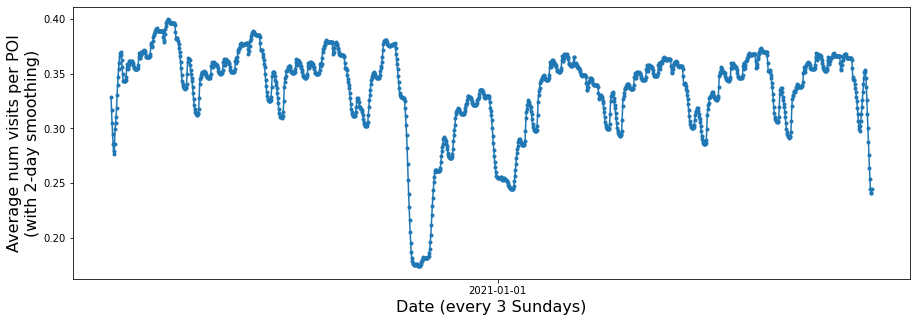

In [56]:
from matplotlib import ticker as tick

fig, ax = plt.subplots(figsize=(15, 5))
x = all_hours
y = apply_smoothing(visits_per_hour, before=24, after=24)
ax.plot_date(x, y, linestyle='-', marker='.')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date (every 3 Sundays)', fontsize=16)
ax.set_ylabel('Average num visits per POI\n(with 2-day smoothing)', fontsize=16)
ax.set_title('%s' % MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.2)
plt.show()

# Post-processing on MSA files: create time-aggregated

In this section, we aggregate data over many weeks to provide time-aggregated estimates for certain POI attributes. 
- During network inference (see generate_ipf.py), we use time-aggregated estimates of each POI's visitors' home CBG distribution.
- In our model (see model_experiments.py), we use time-aggregated estimates for each POI's dwell time.

Since we use time-aggregated estimates, we do not update these values every time we download new SafeGraph data. As of February 2021, we are using the weeks from 2019/12/30 to 2020/10/19 as the basis for time-aggregated information.

In [75]:
pop_df = helper.load_dataframe_to_correct_for_population_size(version='v2', verbose=False)
pop_df.head()

# the output of pop_df has fields of for each week's visitation.
# Each row is a blockgroup

# pop_df = pd.read_csv(PATH_TO_ACS_5YR_DATA)
# pop_df

Processing: 1 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/09/18/home_panel_summary.csv
Processing: 2 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/16/18/home_panel_summary.csv
Processing: 3 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/23/18/home_panel_summary.csv
Processing: 4 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/30/18/home_panel_summary.csv
Processing: 5 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2021/01/06/19/home_panel_summary.csv
Processing: 6 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2021/01/13/19/home_panel_summary.cs

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,INTPTLAT,INTPTLON,Shape_Area,GEOID_Data,county_code,COUNTY_NAME,STATE_ABB,STATE_NAME,cbg_total_population,p_asian,p_black,p_white,CBSA Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,GEOID,total_household_income,total_households,mean_household_income,median_household_income,census_block_group,total_cbg_population,number_devices_residing_2020-12-09,number_devices_residing_2020-12-16,number_devices_residing_2020-12-23,number_devices_residing_2020-12-30,number_devices_residing_2021-01-06,number_devices_residing_2021-01-13,number_devices_residing_2021-01-20,number_devices_residing_2021-01-27,number_devices_residing_2021-02-03,number_devices_residing_2021-02-10,number_devices_residing_2021-02-17,number_devices_residing_2021-02-24,number_devices_residing_2021-03-03,number_devices_residing_2021-03-11,number_devices_residing_2021-03-17,number_devices_residing_2021-03-24,number_devices_residing_2021-03-31,number_devices_residing_2021-04-07,number_devices_residing_2021-04-14,number_devices_residing_2021-04-21,number_devices_residing_2021-04-28,number_devices_residing_2021-05-05,number_devices_residing_2021-05-13,number_devices_residing_2021-05-19,number_devices_residing_2021-05-26,number_devices_residing_2021-06-02,number_devices_residing_2021-06-09,number_devices_residing_2021-06-16,number_devices_residing_2021-06-23,number_devices_residing_2021-06-30,number_devices_residing_2021-07-07,number_devices_residing_2021-07-14
0,1.0,1,73,5903,3,33.603461,-86.680672,2.029247e+06,15000US010730059033,1073,Jefferson,AL,Alabama,1991,0.015068,0.689603,0.286288,13820.0,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059033,38984602.0,811.0,48069.792848,41875,010730059033,1991,125.0,125.0,119.0,120.0,105.0,116.0,120.0,104.0,111.0,106.0,109.0,110.0,107.0,104.0,104.0,105.0,109.0,105.0,121.0,107.0,108.0,109.0,105.0,106.0,102.0,112.0,111.0,113.0,99.0,105.0,113.0,114.0
1,2.0,1,73,5903,1,33.596329,-86.667229,4.292080e+06,15000US010730059031,1073,Jefferson,AL,Alabama,2187,0.000000,0.447188,0.476452,13820.0,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059031,49694694.0,612.0,81200.480392,92649,010730059031,2187,100.0,97.0,92.0,84.0,99.0,100.0,101.0,94.0,99.0,104.0,106.0,86.0,100.0,82.0,87.0,86.0,89.0,86.0,88.0,104.0,95.0,91.0,97.0,98.0,100.0,95.0,97.0,97.0,87.0,94.0,98.0,101.0
2,3.0,1,73,5905,3,33.611071,-86.693884,2.420730e+06,15000US010730059053,1073,Jefferson,AL,Alabama,2741,0.000000,0.788763,0.176943,13820.0,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059053,55382145.5,867.0,63877.907151,48906,010730059053,2741,139.0,130.0,137.0,127.0,142.0,148.0,150.0,125.0,140.0,147.0,149.0,130.0,140.0,156.0,162.0,159.0,159.0,156.0,164.0,169.0,152.0,153.0,153.0,147.0,148.0,163.0,157.0,149.0,138.0,137.0,155.0,162.0
3,4.0,1,73,5905,1,33.595858,-86.702036,1.443893e+06,15000US010730059051,1073,Jefferson,AL,Alabama,1213,0.000000,0.771641,0.228359,13820.0,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059051,26347269.5,517.0,50961.836557,40679,010730059051,1213,54.0,59.0,57.0,42.0,57.0,49.0,48.0,45.0,47.0,46.0,50.0,46.0,43.0,39.0,43.0,42.0,45.0,49.0,53.0,49.0,51.0,51.0,46.0,46.0,40.0,46.0,48.0,42.0,44.0,53.0,48.0,49.0
4,5.0,1,73,5702,3,33.472276,-86.878081,7.353911e+05,15000US010730057023,1073,Jefferson,AL,Alabama,412,0.000000,0.961165,0.038835,13820.0,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730057023,8682417.5,205.0,42353.256098,38669,010730057023,412,39.0,40.0,45.0,46.0,47.0,49.0,51.

In [76]:
len(pop_df)

219216

In [57]:
# constant info: core, area, aggregated dwell time, aggregated home cbgs
def make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None):
    prefix = '%s_%s' % (time_period_strings[0].split('_')[0], time_period_strings[-1].split('_')[1])
    print('Prefix:', prefix)  # results: 20210125_20210201
    pois_in_msa = set()
    if dfs is None:
        dfs = []
        for ts in time_period_strings:
            df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts) # load the msa pois
            pois_in_msa = pois_in_msa.union(df.index)
            dfs.append(df)
    else:
        copied_dfs = []
        for df in dfs:
            copied_dfs.append(df.copy())  # don't want to modify by accident
            pois_in_msa = pois_in_msa.union(df.index)
        dfs = copied_dfs
    
    pois_in_msa = list(sorted(pois_in_msa))
    base = core_poi_df.loc[pois_in_msa].copy()
    parent_ids = set(core_poi_df.parent_safegraph_place_id)
    is_parent = base.index.isin(parent_ids)
    parents = base[is_parent]
    nonparents = base[~is_parent]
    print('In MSA: %d parent POIs; %d non-parent POIs' % (len(parents), len(nonparents)))
    base = nonparents    
    base['poi_cbg'] = np.nan
    for df in dfs:
        visitor_home_cbg_cols = sorted([col for col in df.columns if col.endswith('visitor_home_cbgs')])
        median_dwell_cols = sorted([col for col in df.columns if col.endswith('median_dwell')])
        cols_to_keep = ['single_poi_cbg'] + visitor_home_cbg_cols + median_dwell_cols
        
        df = df.drop_duplicates()
        
        print(f"base len: {len(base)}, df len: {len(df)}")
        
        base = pd.merge(base, df[cols_to_keep], how='left', left_index=True, right_index=True, validate='one_to_one')
        poi_cbg_is_nan = pd.isnull(base['poi_cbg'])  # update poi_cbg data that is still null
        base['poi_cbg'][poi_cbg_is_nan] = base['single_poi_cbg'][poi_cbg_is_nan]  # each df has a single_poi_cbg column
        base = base.drop(columns=['single_poi_cbg'])
    try:
        visitor_home_cbg_cols = [col for col in base.columns if col.endswith('visitor_home_cbgs')]
        print('Found %d visitor home CBG columns' % len(visitor_home_cbg_cols))
        is_null_mat = pd.isnull(base[visitor_home_cbg_cols])
        base['num_weeks_with_visitor_home_cbgs'] = np.sum(~is_null_mat, axis=1)
        periods_to_include = [c[:10] for c in visitor_home_cbg_cols]  # only keep date string
        base = helper.aggregate_visitor_home_cbgs_over_months(base, population_df=pop_df, 
                                                    cutoff_year=None, periods_to_include=periods_to_include)
        base = base.rename(columns={k:'%s_%s' % (prefix, k) for k in ['aggregated_cbg_population_adjusted_visitor_home_cbgs', 
              'aggregated_visitor_home_cbgs']})

        median_dwell_cols = [col for col in base.columns if col.endswith('median_dwell')]
        print('Found %d median dwell columns' % len(median_dwell_cols))
        is_null_mat = pd.isnull(base[median_dwell_cols])
        base['num_weeks_with_median_dwell'] = np.sum(~is_null_mat, axis=1)
        base['%s_median_of_median_dwell' % prefix] = np.nanmedian(base[median_dwell_cols].values, axis=1)

        cols_to_drop = [col for col in base.columns if '.' in col]  # time-varying are <date>.<col_name>
        base = base.drop(columns=cols_to_drop)
        for k in ['%s_aggregated_cbg_population_adjusted_visitor_home_cbgs' % prefix, 
                  '%s_aggregated_visitor_home_cbgs' % prefix]:
            base[k] = base[k].map(lambda x:json.dumps(dict(x))) # cast to json so properly saved in CSV. 
        path_to_csv = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, 'time_aggregated/%s_%s.csv' % (prefix, msa_name))
        print('Saving at', path_to_csv)
        base.to_csv(path_to_csv)
    except Exception as e:
        print("Error in make_time_aggregated_file_for_msa()", msa_name, e)
    return base

In [78]:
stratified_by_msa_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20201209_20210203')
if not os.path.exists(stratified_by_msa_dir):
    os.makedirs(stratified_by_msa_dir)

fns = os.listdir(stratified_by_msa_dir)  # file list
va_msas = []

# get the target state
for fn in fns:
    msa = fn.split('.')[0]  # drop .csv
    states = msa.split('_')[1:]
    # va_msas.append(msa)
    if 'SC' in states:
        va_msas.append(msa)
print('Found %d MSAs that overlap with SC' % len(va_msas))
print(va_msas)

Found 10 MSAs that overlap with SC
['Augusta_Richmond_County_GA_SC', 'Charleston_North_Charleston_SC', 'Charlotte_Concord_Gastonia_NC_SC', 'Columbia_SC', 'Florence_SC', 'Greenville_Anderson_SC', 'Hilton_Head_Island_Bluffton_SC', 'Myrtle_Beach_Conway_North_Myrtle_Beach_SC_NC', 'Spartanburg_SC', 'Sumter_SC']


In [80]:
# time_period_strings = ['20191230_20200224', '20200302_20200608', '20200615_20200817', '20200824_20201019']
time_period_strings = ['20201209_20210630']  # not only a week
for msa_name in va_msas:
    make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None)

Prefix: 20201209_20210630
filename: /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201209_20210630/Augusta_Richmond_County_GA_SC.csv
Loaded 2382 rows for Augusta_Richmond_County_GA_SC in 2.180 seconds
In MSA: 0 parent POIs; 2382 non-parent POIs
base len: 2382, df len: 2382
Found 30 visitor home CBG columns
Aggregating data from: ['2020-12-09.visitor_home_cbgs', '2020-12-16.visitor_home_cbgs', '2020-12-23.visitor_home_cbgs', '2020-12-30.visitor_home_cbgs', '2021-01-06.visitor_home_cbgs', '2021-01-13.visitor_home_cbgs', '2021-01-20.visitor_home_cbgs', '2021-01-27.visitor_home_cbgs', '2021-02-03.visitor_home_cbgs', '2021-02-10.visitor_home_cbgs', '2021-02-17.visitor_home_cbgs', '2021-02-24.visitor_home_cbgs', '2021-03-03.visitor_home_cbgs', '2021-03-11.visitor_home_cbgs', '2021-03-17.visitor_home_cbgs', '2021-03-24.visitor_home_cbgs', '2021-03-31.visitor_home_cbgs', '2021-04-07.visitor_home_cbgs', '2021-04-14.visitor_home_cbgs', '2021-04-21.visitor_home_cbgs', '2021-04

/media/gpu/easystore/covid-mobility-tool/env_v2/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finished adjusting home CBG counts for 2020-12-16 [time=0.051s] had to fill in or clip coverage for 62.552477% of rows; in those cases used median coverage 0.042
Filling 2020-12-23.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2020-12-23 [time=0.051s] had to fill in or clip coverage for 62.510495% of rows; in those cases used median coverage 0.042
Filling 2020-12-30.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2020-12-30 [time=0.050s] had to fill in or clip coverage for 57.850546% of rows; in those cases used median coverage 0.039
Filling 2021-01-06.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2021-01-06 [time=0.049s] had to fill in or clip coverage for 57.934509% of rows; in those cases used median coverage 0.041
Filling 2021-01-13.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2021-01-13 [time=0.051s] had to fill in or clip coverage for 64.525609% of rows; 

Final columns:

safegraph_place_id

parent_safegraph_place_id

location_name

safegraph_brand_ids

brands

top_category

sub_category

naics_code

latitude

longitude

street_address

city

region

postal_code

open_hours

polygon_class

area_square_feet

poi_cbg

num_weeks_with_visitor_home_cbgs

20210106_20210120_aggregated_visitor_home_cbgs

20210106_20210120_aggregated_cbg_population_adjusted_visitor_home_cbgs

num_weeks_with_median_dwell

20210106_20210120_median_of_median_dwell

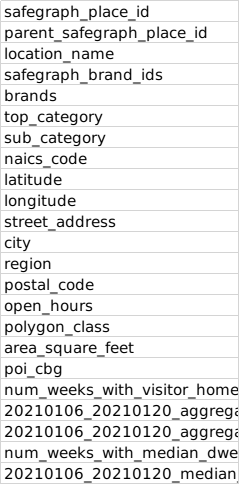


In [ ]:
import pyan
from IPython.display import HTML
HTML(pyan.create_callgraph(filenames="**/*.py", format="html"))


In [20]:
import numpy as np
import pandas as pd

npz_file = r'/media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2020-12-28-10.npz'


np.load(npz_file)['data'].sum()

65648.91847540307

In [8]:
np.load(npz_file).files

['indices', 'indptr', 'format', 'shape', 'data']

In [16]:
np.load(npz_file)['data'].sum()

56264.93643118425

In [ ]:
import numpy as np
import pandas as pd

npz_file = r'/media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2021-01-31-14.npz'


np.array(np.load(npz_file)['data']).shape